In [ ]:
import json
import requests

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from fiber.database.hana import engine as hana_engine
from fiber.database.mysql import engine as mysql_engine
from fiber.utils import Timer

In [ ]:
def slack_notification(text):
    webhook_url = 'https://hooks.slack.com/services/xxxx/yyyy'
    slack_data = {'text': text}

    response = requests.post(
        webhook_url, data=json.dumps(slack_data),
        headers={'Content-Type': 'application/json'}
    )
    if response.status_code != 200:
        raise ValueError(
            'Request to slack returned an error %s, the response is:\n%s'
            % (response.status_code, response.text)
        )

# `Procedure('35.%', 'ICD-9') | Procedure('36.1%', 'ICD-9')`

This notebook executes the benchmark for the creation of a cohort from a condition.
In this example two ICD-9 groups are disjoint and catch all valve and bypass surgeries.

The queries in `build_query` emulate FIBER's translation process.
However, they have a possibility to limit the number of included MRNs in the result, which should control the result size.

The benchmark is run for up to 15,000 medical record numbers and reports the execution and fetching time of the queries on HANA and MySQL.

In [ ]:
def build_query(limit):
    hana_query = """
        SELECT DISTINCT "MSDW_2018"."D_PERSON"."MEDICAL_RECORD_NUMBER"
        FROM "MSDW_2018"."FACT"
            JOIN "MSDW_2018"."D_PERSON" ON "MSDW_2018"."FACT"."PERSON_KEY" = "MSDW_2018"."D_PERSON"."PERSON_KEY"
            JOIN "MSDW_2018"."B_PROCEDURE" ON "MSDW_2018"."FACT"."PROCEDURE_GROUP_KEY" = "MSDW_2018"."B_PROCEDURE"."PROCEDURE_GROUP_KEY"
            JOIN "MSDW_2018"."FD_PROCEDURE" ON "MSDW_2018"."FD_PROCEDURE"."PROCEDURE_KEY" = "MSDW_2018"."B_PROCEDURE"."PROCEDURE_KEY"
        WHERE "MSDW_2018"."FACT"."AGE_IN_DAYS" >= 6570
          AND "MSDW_2018"."FD_PROCEDURE"."CONTEXT_NAME" LIKE 'ICD-9'
          AND upper("MSDW_2018"."FD_PROCEDURE"."CONTEXT_PROCEDURE_CODE") LIKE '35.%'
          OR "MSDW_2018"."FACT"."AGE_IN_DAYS" >= 6570
          AND "MSDW_2018"."FD_PROCEDURE"."CONTEXT_NAME" LIKE 'ICD-9'
          AND upper("MSDW_2018"."FD_PROCEDURE"."CONTEXT_PROCEDURE_CODE") LIKE '36.1%'
        LIMIT 
    """ + str(limit)

    mysql_query = """
        SELECT DISTINCT `D_PERSON`.`MEDICAL_RECORD_NUMBER`
        FROM `FACT`
            INNER JOIN `D_PERSON` ON `FACT`.`PERSON_KEY` = `D_PERSON`.`PERSON_KEY`
            INNER JOIN `B_PROCEDURE` ON `FACT`.`PROCEDURE_GROUP_KEY` = `B_PROCEDURE`.`PROCEDURE_GROUP_KEY`
            INNER JOIN `FD_PROCEDURE` ON `FD_PROCEDURE`.`PROCEDURE_KEY` = `B_PROCEDURE`.`PROCEDURE_KEY`
        WHERE `FACT`.`AGE_IN_DAYS` >= 6570
          AND `FD_PROCEDURE`.`CONTEXT_NAME` LIKE 'ICD-9'
          AND upper(`FD_PROCEDURE`.`CONTEXT_PROCEDURE_CODE`) LIKE '35.%%'
          OR `FACT`.`AGE_IN_DAYS` >= 6570
          AND `FD_PROCEDURE`.`CONTEXT_NAME` LIKE 'ICD-9'
          AND upper(`FD_PROCEDURE`.`CONTEXT_PROCEDURE_CODE`) LIKE '36.1%%'
        LIMIT 
    """ + str(limit)
    return (hana_query, mysql_query)

In [ ]:
def execute_benchmark(limits, query_builder):
    hana_benchmark_results = []
    mysql_benchmark_results = []
    for limit in limits:
        queries = query_builder(limit)
        with Timer() as t:
            pd.read_sql(queries[0], hana_engine)
        hana_benchmark_results.append([limit, t.elapsed])
        with Timer() as t:
            pd.read_sql(queries[1], mysql_engine)
        mysql_benchmark_results.append([limit, t.elapsed])
        
        slack_notification(f'Done {str(limit)} medical record numbers')
    return (
        pd.DataFrame(hana_benchmark_results, columns=['# Patients', 'Runtime in s']),
        pd.DataFrame(mysql_benchmark_results, columns=['# Patients', 'Runtime in s'])
    )

In [ ]:
limits = [10, 100, 500, 1000, 5000, 10000, 15000]
hana_results, mysql_results = execute_benchmark(limits, build_query)

### Result Persisting

In [ ]:
hana_results.to_csv('../results/cohort/hana.csv', index=False)
mysql_results.to_csv('../results/cohort/mysql.csv', index=False)

In [ ]:
hana_results = pd.read_csv('../results/cohort/hana.csv')
mysql_results = pd.read_csv('../results/cohort/mysql.csv')

### Visualization

In [ ]:
hana_results.plot.line(x='# Patients', y='Runtime in s')

In [ ]:
mysql_results.plot.line(x='# Patients', y='Runtime in s')

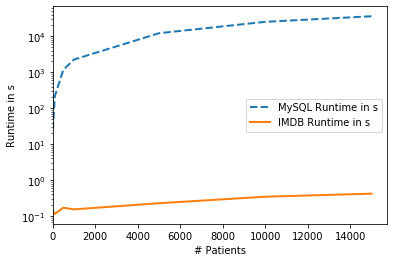

In [26]:
results = pd.merge(mysql_results, hana_results, on='# Patients')
results.rename(columns={'Runtime in s_x': 'MySQL Runtime in s', 'Runtime in s_y': 'IMDB Runtime in s'}, inplace=True)

plt.figure()

plt.plot(results['# Patients'], results['MySQL Runtime in s'], '--', linewidth=2, markersize=12, label='MySQL Runtime in s')
plt.plot(results['# Patients'], results['IMDB Runtime in s'], '-', linewidth=2, markersize=12, label='IMDB Runtime in s')
plt.yscale('log')
plt.ylabel('Runtime in s')
plt.xlabel('# Patients')
plt.xlim(0)
plt.legend()
plt.savefig('../figures/cohort/runtime.png', dpi=600, bbox_inches="tight")